# TESS Mission model training

## Dependencies

In [42]:
import pandas as pd
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import requests
import joblib
import random as rand
from sklearn.preprocessing import StandardScaler

## Consuming the latest available TESS exoplanets database

In [43]:
print("Downloading TESS mission data...")
url = 'https://exoplanetarchive.ipac.caltech.edu/cgi-bin/IceTable/nph-iceTblDownload'
tess_payload = {
    "workspace": "2025.10.01_20.06.09_019818/TblView/2025.10.04_08.07.24_035625",
    "useTimestamp": 1,
    "table": "/exodata/kvmexoweb/ExoTables/TOI.tbl",
    "format": "CSV",
    "user": "",
    "label": "",
    "columns": "all",
    "rows": "all",
    "mission": "ExoplanetArchive"
}
response = requests.post(url, data=tess_payload)
filename = "tess_db.csv"
with open(filename, "wb") as f:
    f.write(response.content)
print("TESS mission data downloaded!")

TESS mission data downloaded!


## Definition of the neural network architecture

In [44]:
def build_mlp(column_count):
    inputs = keras.Input(shape=(column_count,))
    
    x = keras.layers.Dense(32)(inputs)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Dropout(0.3)(x)

    x = keras.layers.Dense(16)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Dropout(0.2)(x)

    x = keras.layers.Dense(8)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Dropout(0.2)(x)
    
    output = keras.layers.Dense(1, activation='sigmoid')(x)
    return keras.Model(inputs, output)

## Data preprocessing

In [45]:

df = pd.read_csv(filename, comment='#')
cols_to_drop = [
    "rowid", "toi", "toipfx", "tid", "ctoi_alias", "pl_pnum",
    "rastr", "raerr1", "raerr2", "decstr", "dec", "decerr1", "decerr2",
    "st_pmralim", "st_pmrasymerr",
    "st_pmdeclim", "st_pmdecsymerr",
    "pl_tranmidlim", "pl_tranmidsymerr",
    "pl_orbperlim", "pl_orbpersymerr",
    "pl_trandurhlim", "pl_trandurhsymerr",
    "pl_trandeplim", "pl_trandepsymerr",
    "pl_radelim", "pl_radesymerr",
    "pl_insolerr1", "pl_insolerr2", "pl_insollim", "pl_insolsymerr",
    "pl_eqterr1", "pl_eqterr2", "pl_eqtlim", "pl_eqtsymerr",
    "st_tmaglim", "st_tmagsymerr",
    "st_distlim", "st_distsymerr",
    "st_tefflim", "st_teffsymerr",
    "st_logglim", "st_loggsymerr",
    "st_radlim", "st_radsymerr",
    "toi_created", "rowupdate"
]

df = df.drop(columns=cols_to_drop).reset_index(drop=True)

Y = df['tfopwg_disp'].map({'FP': 0, 'FA': 0, 'CP': 1, 'KP': 1})
X = df.drop(columns=['tfopwg_disp'])
X_filled = X.fillna(0)
X_encoded = pd.get_dummies(X_filled, drop_first=False).astype(np.float32)

mask = Y.notna()
X_encoded = X_encoded[mask]
Y = Y[mask].astype(np.float32)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded).astype(np.float32)
joblib.dump(scaler, 'tess_scaler.pkl')


['tess_scaler.pkl']

## Train/test split

In [46]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X_scaled, Y, test_size=0.2, random_state=42, shuffle=True
)

## Neural network compilation

In [47]:
model = build_mlp(X_encoded.shape[1])
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='binary_crossentropy'
)
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 39)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 8)              │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,177 (8.50 KB)

 Trainable params: 2,065 (8.07 KB)

 Non-trainable params: 112 (448.00 B)

## Training callbacks

In [48]:
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=50,
    restore_best_weights=True
)

## Model fitting

In [49]:
model.fit(
    X_train, Y_train,
    batch_size=64,
    epochs=1000,
    validation_split=0.1,
    callbacks=[early_stop]
)

Epoch 1/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 113ms/step - loss: 0.7230 - val_loss: 0.6947
Epoch 2/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6790 - val_loss: 0.6541
Epoch 3/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6455 - val_loss: 0.6130
Epoch 4/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6322 - val_loss: 0.5784
Epoch 5/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5991 - val_loss: 0.5483
Epoch 6/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5871 - val_loss: 0.5242
Epoch 7/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5784 - val_loss: 0.5018
Epoch 8/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5577 - val_loss: 0.4765
Epoch 9/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5376 - val_loss: 0.4651
Epoch 10/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5251 - val_loss: 0.4501
Epoch 11/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5171 - val_loss: 0.4353
Epoch 12/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/st

In [50]:
model.save('tess.keras')

## Testing and model evaluation

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
                precision    recall  f1-score   support

FALSE POSITIVE       0.89      0.86      0.87       245
     CONFIRMED       0.88      0.90      0.89       268

      accuracy                           0.88       513
     macro avg       0.88      0.88      0.88       513
  weighted avg       0.88      0.88      0.88       513



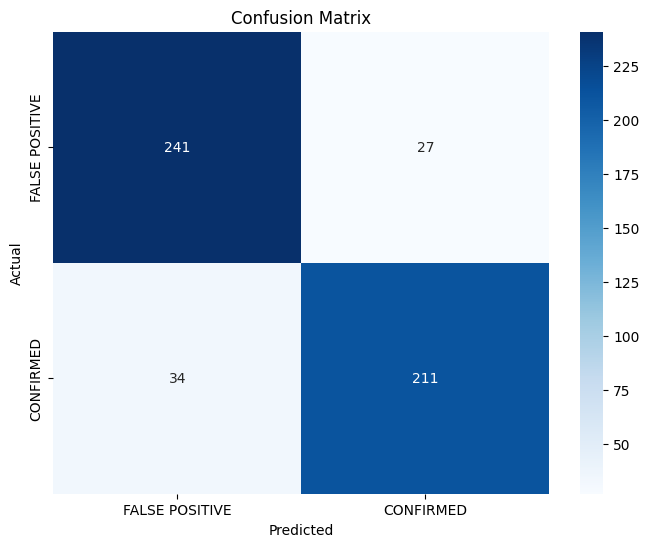

In [51]:
labels = ['FALSE POSITIVE', 'CONFIRMED']

Y_pred_probs = model.predict(X_test)
Y_pred = (Y_pred_probs >= 0.5).astype(int).flatten()
Y_true = Y_test.values.astype(int).flatten() 

Y_pred_strings = [labels[i] for i in Y_pred]
Y_true_strings = [labels[i] for i in Y_true]

cm = confusion_matrix(Y_true_strings, Y_pred_strings, labels=labels)
print(classification_report(Y_true_strings, Y_pred_strings, target_names=labels))
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# TESS model inference

## Data preprocessing

In [52]:
filename = "tess_db.csv"
df = pd.read_csv(filename, comment='#')
cols_to_drop = [
    "rowid",'tfopwg_disp', "toi", "toipfx", "tid", "ctoi_alias", "pl_pnum",
    "rastr", "raerr1", "raerr2", "decstr", "dec", "decerr1", "decerr2",
    "st_pmralim", "st_pmrasymerr",
    "st_pmdeclim", "st_pmdecsymerr",
    "pl_tranmidlim", "pl_tranmidsymerr",
    "pl_orbperlim", "pl_orbpersymerr",
    "pl_trandurhlim", "pl_trandurhsymerr",
    "pl_trandeplim", "pl_trandepsymerr",
    "pl_radelim", "pl_radesymerr",
    "pl_insolerr1", "pl_insolerr2", "pl_insollim", "pl_insolsymerr",
    "pl_eqterr1", "pl_eqterr2", "pl_eqtlim", "pl_eqtsymerr",
    "st_tmaglim", "st_tmagsymerr",
    "st_distlim", "st_distsymerr",
    "st_tefflim", "st_teffsymerr",
    "st_logglim", "st_loggsymerr",
    "st_radlim", "st_radsymerr",
    "toi_created", "rowupdate"
]
df_clean = df.drop(columns=cols_to_drop).reset_index(drop=True)

Y = df['tfopwg_disp'].map({'FP': 0, 'FA': 0, 'CP': 1, 'KP': 1})
X = df.drop(columns=cols_to_drop)
X_filled = X.fillna(0)
X_encoded = pd.get_dummies(X_filled, drop_first=False).astype(np.float32)

mask = Y.isna()
X_encoded = X_encoded[mask]
scaler = joblib.load('tess_scaler.pkl')
X_scaled = scaler.transform(X_encoded).astype(np.float32)

## Predictions generation

In [53]:
labels = ['FALSE POSITIVE', 'CONFIRMED']
model = keras.models.load_model('tess.keras')
pred_org = model.predict(X_scaled)
pred = (pred_org >= 0.5).astype(int).flatten()

161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


## Saving predictions

In [54]:
candidates_meta = df.loc[mask, ['toi']]

with open('tess_predictions.csv', 'w') as f:
    f.write('tid,toi,tfopwg_disp_pred,tfopwg_disp_pred_value\n')
    for i, (_, row) in enumerate(candidates_meta.iterrows()):
        f.write(f"{row['tid']},{row['toi']},{labels[pred[i]]},{pred_org[i][0]}\n")

KeyError: 'tid'

# TESS Exoplanet candidates catalog export to Celestia
This section of the notebook processes the **TESS mission exoplanet catalog** to generate `.stc`, `.ssc`, and `.cel` files compatible with **Celestia**.

## Function definitions

In [ ]:
G = 6.67430e-11
R_sun = 6.957e8
M_sun = 1.989e30
L_sun = 3.828e26
sigma = 5.670374419e-8

def estimate_semimajor_axis(row):
    try:
        if pd.isna(row.get("pl_orbper")) or pd.isna(row.get("st_rad")) or pd.isna(row.get("st_logg")):
            return np.nan
        R_star = row["st_rad"] * R_sun
        g_cgs = 10 ** row["st_logg"]
        g = g_cgs / 100.0
        M_star = g * R_star**2 / G
        P_sec = row["pl_orbper"] * 86400.0
        a_m = (G * M_star * P_sec**2 / (4 * np.pi**2))**(1/3)
        a_au = a_m / 1.496e11
        return a_au
    except Exception:
        return np.nan

def generate_star(star_id, star_name, ra, dec, distance_ly, appmag, spectral_type):
    entry = ''
    entry += f'{star_id} "{star_name}" {{\n'
    entry += f'    RA {ra:.6f}\n'
    entry += f'    Dec {dec:.6f}\n'
    entry += f'    Distance {distance_ly:.2f}\n'
    entry += f'    SpectralType "{spectral_type}"\n'
    entry += f'    AppMag {appmag:.2f}\n'
    entry += '}\n\n'
    return entry

textures = [
    'GJ_504_b.jpg','HAT-P-11_b.jpg','Kepler-452_b.jpg','Proxima_Cen_b.jpg',
    'HD_189733_b.jpg','Kepler-7_b.jpg','YZ_Cet_d.jpg','Kepler-22_b.jpg',
    'OGLE-2005-BLG-390L_b.jpg','exo-class1.*','exo-class2.*','exo-class3.*',
    'exo-class4.*','exo-class5.*','venuslike.*','asteroid.*'
]

def generate_planet(star_name, planet_name, radius_km, period, semimajoraxis, eccentricity, inclination):
    entry = ''
    texture = rand.choice(textures)
    entry += f'"{planet_name}" "{star_name}"\n'
    entry += '{\n'
    entry += '    Class "Planet"\n'
    entry += f'    Radius {radius_km:.2f}\n'
    entry += f'    Texture "{texture}"\n'
    if not (pd.isna(period) and pd.isna(semimajoraxis)):
        entry += '    EllipticalOrbit\n'
        entry += '    {\n'
        if not pd.isna(period):
            entry += f'        Period {period:.6f}\n'
        if not pd.isna(semimajoraxis):
            entry += f'        SemiMajorAxis {semimajoraxis:.6f}\n'
        entry += f'        Eccentricity {0.0 if pd.isna(eccentricity) else eccentricity:.6f}\n'
        entry += f'        Inclination {0.0 if pd.isna(inclination) else inclination:.6f}\n'
        entry += '    }\n'
    entry += '}\n\n'
    return entry

def generate_script_entry(planet_name, star_name, distance_ly, pred, value):
    text = f'Planet: {planet_name}\nApprox. {round(distance_ly,2)} light years away from Earth\n'
    if str(pred).upper() == "CONFIRMED":
        text += "Prediction: Real exoplanet\n"
        text += f'Confidence: {int(value*100)}%'
    elif str(pred).upper() == "FALSE POSITIVE":
        text += 'Prediction: False positive\n'
        text += f'Confidence: {int((1-value)*100)}%'
    else:
        text += "Prediction: unknown\n"
    entry = ''
    entry += f'select {{object "{star_name}"}}\n'
    entry += f'select {{object "{planet_name}"}}\n'
    entry += 'goto { time 6 distance 5 }\n'
    entry += 'wait { duration 6 }\n'
    entry += f'print {{ text "{text}"\n'
    entry += '         origin "top"\n'
    entry += '         row 5\n'
    entry += '         column -8\n'
    entry += '         duration 6 }\n'
    entry += 'orbit {duration 6 rate 60 axis [0 1 0] }\n\n'
    return entry


## Folder structure declaration

In [ ]:
tess_file = "tess_db.csv"
tess_predictions_file = "tess_predictions.csv"
local_extras = "extras"
os.makedirs(local_extras, exist_ok=True)
scripts_dir = os.path.join(local_extras, "Scripts")
os.makedirs(scripts_dir, exist_ok=True)

## Loading predictions from file

In [ ]:
df_tess = pd.read_csv(tess_file, comment="#")
df_tess_candidates = df_tess[df_tess["tfopwg_disp"] == "PC"].copy()
df_tess_candidates["distance_ly"] = df_tess_candidates["st_dist"] * 3.26156

tess_predictions = pd.read_csv(tess_predictions_file)
tess_predictions = tess_predictions[tess_predictions["tfopwg_disp_pred"] == "CONFIRMED"].copy()
df_tess_candidates = df_tess_candidates.merge(
    tess_predictions[["toi", 'tid', "tfopwg_disp_pred", "tfopwg_disp_pred_value"]],
    on="toi",
    how="inner"
)

## Generating host stars catalog

In [ ]:
tess_stars_stc_path = os.path.join(local_extras, "toi_hosts.stc")
with open(tess_stars_stc_path, "w") as stc_file:
    for idx, row in df_tess_candidates.iterrows():
        if pd.isna(row.get("pl_rade")):
            continue
        entry = generate_star(
            star_id=int(row['tid']),
            star_name=f'Star-{row["toi"]}',
            ra=row["ra"],
            dec=row["dec"],
            distance_ly=row["distance_ly"],
            appmag=row["st_tmag"] if pd.notna(row.get("st_tmag")) else 12,
            spectral_type="G0"
        )
        stc_file.write(entry)

print(tess_stars_stc_path)


extras/toi_hosts.stc


## Generating candidate exoplanets catalog

In [ ]:
tess_planets_ssc_path = os.path.join(local_extras, "toi_candidates.ssc")
with open(tess_planets_ssc_path, "w") as ssc_file:
    for idx, row in df_tess_candidates.iterrows():
        if pd.isna(row.get("pl_rade")):
            continue
        radius_km = row["pl_rade"] * 6378.0
        sma = estimate_semimajor_axis(row)
        entry = generate_planet(
            star_name=f'Star-{row["toi"]}',
            planet_name=f'TOI-{row["toi"]}',
            radius_km=radius_km,
            period=row.get("pl_orbper"),
            semimajoraxis=sma,
            eccentricity=0.0,
            inclination=0.0
        )
        ssc_file.write(entry)

print(tess_planets_ssc_path)


extras/toi_candidates.ssc


## Generating TESS visualizer script

In [ ]:
tess_cel_file_path = os.path.join(scripts_dir, "toi_candidates.cel")
with open(tess_cel_file_path, "w") as f_cel:
    f_cel.write("{\n")
    f_cel.write('select {object "Earth"}\n')
    f_cel.write('changedistance {duration 8 rate 4}\n')
    for idx, row in df_tess_candidates.iterrows():
        if pd.isna(row.get("pl_rade")):
            continue
        entry = generate_script_entry(
            planet_name=f'TOI-{row["toi"]}',
            star_name=f'Star-{row["toi"]}',
            distance_ly=row.get("distance_ly", 0),
            pred=row.get("tfopwg_disp_pred", "unknown"),
            value=float(row.get("tfopwg_disp_pred_value", 0.5)) if not pd.isna(row.get("tfopwg_disp_pred_value")) else 0.5
        )
        f_cel.write(entry)
    f_cel.write("}\n")

print(tess_cel_file_path)

extras/Scripts/toi_candidates.cel
